# Exercise 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio          # For reading .mat file
%matplotlib inline
import seaborn as sns
sns.set()
import random

## Logistic Regression One-vs-All

### Load data

In [2]:
data = sio.loadmat('ex3data1.mat')
data

{'X': array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Oct 16 13:09:09 2011',
 '__version__': '1.0',
 'y': array([[10],
        [10],
        [10],
        ...,
        [ 9],
        [ 9],
        [ 9]], dtype=uint8)}

In [3]:
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

### A different approach to handle the displayData function
Might take longer to load the plot than Andrew's original Octave function

In [4]:
def restoreImg(data):
    '''Restore an image for properly displaying.
       Would be called in function displayData'''
    data = data * 255       # Get actual gray values
    data = data.reshape(20, 20)
    data = np.flip(data, 0)    # Have to flip and rotate the image for proper displaying
    data = np.rot90(data, k=1, axes=(1,0))
    return data

def displayData(data):
    '''Display 2D data in a nice grid'''
    plt.figure(figsize=(8, 8))
    if data.shape == (len(data),):
        plt.imshow(restoreImg(data), cmap='gray')
        plt.axis('off')
    else:
        grid_rows = int(np.floor(np.sqrt(len(data))))
        grid_cols = int(np.ceil(len(data) / grid_rows))
        n = 0
        for i in range(grid_rows):
            for j in range(grid_cols):
                ax = plt.subplot2grid((grid_rows, grid_cols), (i, j))
                try:
                    ax.imshow(restoreImg(data[n, :]), cmap='gray')
                except:
                    pass
                plt.axis('off')
                n += 1
    plt.show()

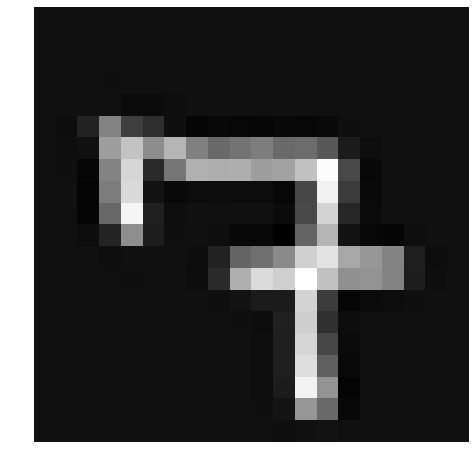

In [5]:
rand_indices = list(range(len(X)))
random.shuffle(rand_indices)
sel = X[rand_indices[:100]]

displayData(sel[99])

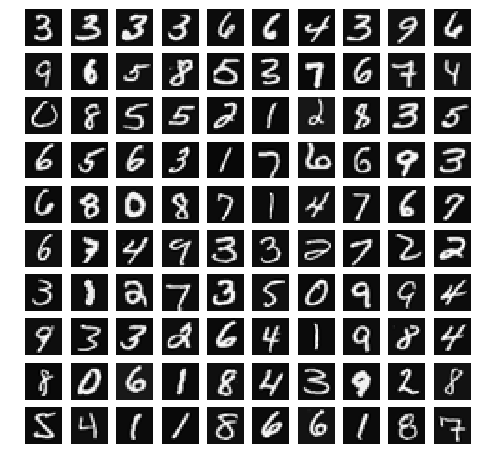

In [6]:
displayData(sel)

### Sigmoid, cost and gradient functions for Logistic Regression

In [7]:
def sigmoid(z):
    '''Compute sigmoid functoon'''
    return 1 / (np.e**(-z) + 1)

def lrCostFunction(theta, X, y, lmd):
    '''Compute cost for logistic regression with regularization'''
    theta = theta.reshape(X.shape[1], 1)
    h = sigmoid(X @ theta)
    cost = (-1*y.T @ np.log(h) - (1-y).T @ np.log(1-h)) / len(y)
    reg = lmd/2/len(y) * sum(theta[1:]**2)
    return  (cost + reg).flatten()
    
def lrGradientFunction(theta, X, y, lmd):
    '''Compute gradient for logistic regression with regularization'''
    theta = theta.reshape(X.shape[1], 1)
    y = y.reshape((len(y), 1))
    h = sigmoid(X @ theta)
    grad0 = (X[:, 0].T @ (h-y) / len(y))
    grad1 = ((X[:, 1:].T @ (h-y)) / len(y) + lmd/len(y) * theta[1:]).flatten()
    return np.insert(grad1, 0, grad0)

### Test functions

In [8]:
theta_t = np.array([-2, -1, 1, 2])
X_t = np.c_[np.ones((5, 1)), np.arange(1, 16).reshape((5, 3), order='F') / 10]
y_t = np.array([1, 0, 1, 0, 1]) >= .5
lmd_t = 3

J = lrCostFunction(theta_t, X_t, y_t, lmd_t)
grad = lrGradientFunction(theta_t, X_t, y_t, lmd_t)

print('Cost: %f'%J)
print('Gradients:', grad)

Cost: 2.534819
Gradients: [ 0.14656137 -0.54855841  0.72472227  1.39800296]


### One vs All function and predict function

In [9]:
def oneVsAll(X, y, num_labels, lmd, maxiter=50):
    '''Trains multiple logistic regression classifiers and returns all 
       the classifiers in a matrix all_theta, where the i-th row of all_theta 
       corresponds to the classifier for label i'''
    from scipy.optimize import fmin_cg
    n = X.shape[1]
    y[y==10] = 0      # Octave counts starting from 1, while Python from 0. Replacement needed.
    
    all_theta = np.zeros((num_labels, n+1))
    X = np.c_[np.ones((X.shape[0], 1)), X]
    
    for k in range(num_labels):
        initial_theta = np.zeros((n+1, 1))
        theta = fmin_cg(lrCostFunction, initial_theta, lrGradientFunction, 
                         args=(X, y==k, lmd), maxiter=maxiter)    # y==k is a key setting here
        all_theta[k, :] = theta.T
    return all_theta


def predictOneVsAll(all_theta, X):
    '''Predict the label for a trained one-vs-all classifier'''
    X = np.c_[np.ones((X.shape[0], 1)), X]
    p_all = X @ all_theta.T
    return p_all.argmax(axis=1)      # .argmax() returns the indices of corresponding values

### Test the functions

In [10]:
num_labels = 10
lmd = .1
all_theta = oneVsAll(X, y, num_labels, lmd)

         Current function value: 0.009110
         Iterations: 50
         Function evaluations: 182
         Gradient evaluations: 182
         Current function value: 0.014947
         Iterations: 50
         Function evaluations: 178
         Gradient evaluations: 178
         Current function value: 0.058096
         Iterations: 50
         Function evaluations: 138
         Gradient evaluations: 138
         Current function value: 0.061957
         Iterations: 50
         Function evaluations: 139
         Gradient evaluations: 139
         Current function value: 0.037401
         Iterations: 50
         Function evaluations: 154
         Gradient evaluations: 154
         Current function value: 0.063631
         Iterations: 50
         Function evaluations: 131
         Gradient evaluations: 131
         Current function value: 0.020033
         Iterations: 50
         Function evaluations: 175
         Gradient evaluations: 175
         Current function value: 0.033653
      

In [11]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy:\n', np.mean(pred == y.reshape(len(y))) * 100)

Training Set Accuracy:
 95.08


### As is seen, 50 iterations can't yield best result. Try a bigger maxiter value.

In [12]:
all_theta = oneVsAll(X, y, num_labels, lmd, 500)

Optimization terminated successfully.
         Current function value: 0.008577
         Iterations: 104
         Function evaluations: 403
         Gradient evaluations: 403
Optimization terminated successfully.
         Current function value: 0.013125
         Iterations: 118
         Function evaluations: 444
         Gradient evaluations: 444
Optimization terminated successfully.
         Current function value: 0.050816
         Iterations: 246
         Function evaluations: 740
         Gradient evaluations: 740
Optimization terminated successfully.
         Current function value: 0.057607
         Iterations: 250
         Function evaluations: 738
         Gradient evaluations: 738
Optimization terminated successfully.
         Current function value: 0.033093
         Iterations: 242
         Function evaluations: 803
         Gradient evaluations: 803
Optimization terminated successfully.
         Current function value: 0.054473
         Iterations: 226
         Function ev

In [13]:
pred = predictOneVsAll(all_theta, X)
print('Training Set Accuracy:\n', np.mean(pred == y.reshape(len(y))) * 100)

Training Set Accuracy:
 96.46000000000001


## ==========
## Neural Network

### Load data

In [14]:
data = sio.loadmat('ex3data1.mat')
X = data['X']
y = data['y']
X.shape, y.shape

((5000, 400), (5000, 1))

### Load prameters and Implement  Predict

In [15]:
wghts = sio.loadmat('ex3weights.mat')
wghts.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Theta1', 'Theta2'])

In [16]:
Theta1 = wghts['Theta1']
Theta2 = wghts['Theta2']
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

In [17]:
def predict(Theta1, Theta2, X):
    '''Predict the label of an input given a trained neural network'''
    X = np.c_[np.ones((len(X), 1)), X]
    
    # Layer 2
    z2 = X @ Theta1.T
    a2 = sigmoid(z2)
    a2 = np.c_[np.ones((len(a2), 1)), a2]
    
    # Output layer
    z3 = a2 @ Theta2.T
    a3 = sigmoid(z3)
    return a3.argmax(axis=1) + 1  # Plus 1 to balance the Octave/Python start number difference

In [18]:
pred = predict(Theta1, Theta2, X)
print('Training Set Accuracy: ', np.mean(pred == y.reshape(len(y))) * 100)

Training Set Accuracy:  97.52


### Randomly permute examples

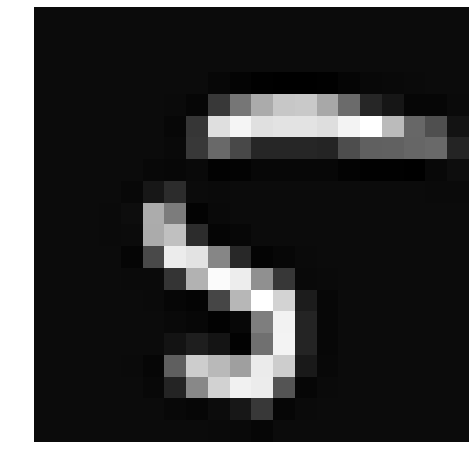

Neural Network prediction: 5 (digit 5)
Paused - Press Enter to continue, q to exit:


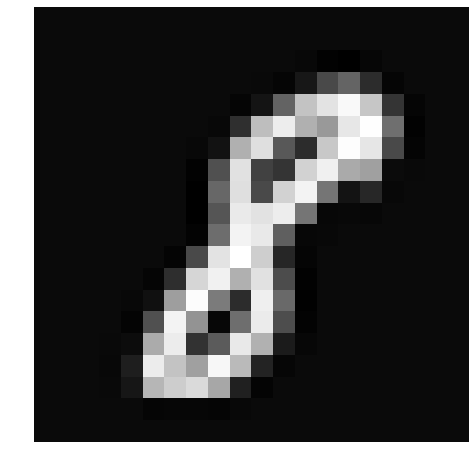

Neural Network prediction: 8 (digit 8)
Paused - Press Enter to continue, q to exit:


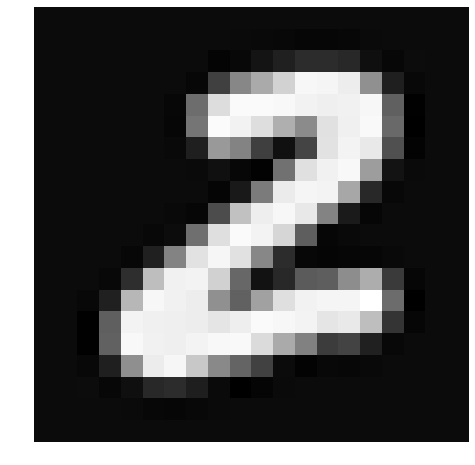

Neural Network prediction: 2 (digit 2)
Paused - Press Enter to continue, q to exit:


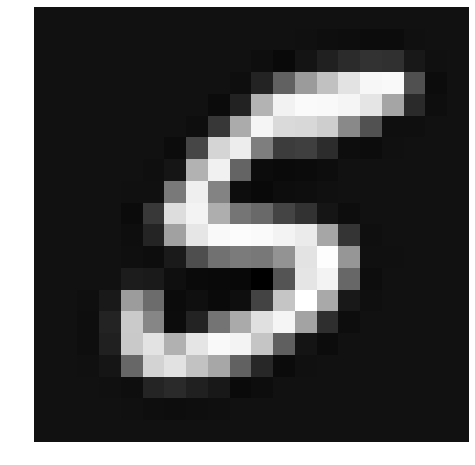

Neural Network prediction: 5 (digit 5)
Paused - Press Enter to continue, q to exit:


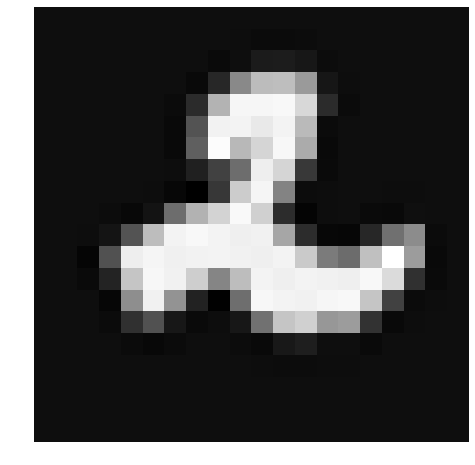

Neural Network prediction: 2 (digit 2)
Paused - Press Enter to continue, q to exit:


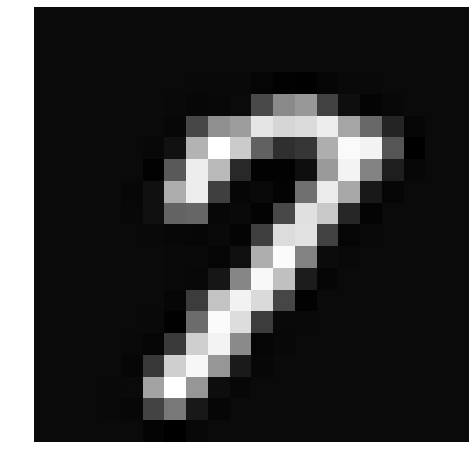

Neural Network prediction: 7 (digit 7)
Paused - Press Enter to continue, q to exit:q


In [20]:
rp = list(range(len(X)))
random.shuffle(rp)
for i in range(len(X)):
    displayData(X[rp[i]])
    pred = predict(Theta1, Theta2, X[rp[i]].reshape(1, 400))
    print('Neural Network prediction: {} (digit {})'.format(pred[0], y[rp[i]][0]))
    s = input('Paused - Press Enter to continue, q to exit:')
    if s == 'q':
        break